In [1]:
!git clone https://github.com/aresu-1704/ultralytics_cbam_custom.git
%cd ultralytics_cbam_custom
!pip install -e .

Cloning into 'ultralytics_cbam_custom'...
remote: Enumerating objects: 877, done.
remote: Counting objects: 100% (877/877), done.
remote: Compressing objects: 100% (680/680), done.
remote: Total 877 (delta 189), reused 868 (delta 185), pack-reused 0 (from 0)
Receiving objects: 100% (877/877), 2.10 MiB | 8.38 MiB/s, done.
Resolving deltas: 100% (189/189), done.
/kaggle/working/ultralytics_cbam_custom
Obtaining file:///kaggle/working/ultralytics_cbam_custom
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 22

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [3]:
%%writefile yolov10n-VT.yaml
nc: 9
scale: n
channels: 3
scales:
  n: [0.33, 0.25, 1024]

backbone:
  - [ -1, 1, Conv, [64, 3, 2] ]
  - [ -1, 1, Conv, [128, 3, 2] ]
  - [ -1, 3, C3k2, [128, True] ]

  - [ -1, 1, Conv, [256, 3, 2] ]
  - [ -1, 1, CBAM, [256] ]
  - [ -1, 6, C3k2, [256, True] ]

  - [ -1, 1, SCDown, [512, 3, 2] ]
  - [ -1, 1, CBAM, [512] ]
  - [ -1, 6, C3k2, [512, True] ]

  - [ -1, 1, SCDown, [1024, 3, 2] ]
  - [ -1, 1, CBAM, [1024] ]
  - [ -1, 3, C3k2, [1024, True] ]
  - [ -1, 1, SPPF, [1024, 5] ]

head:
  - [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ]
  - [ [ -1, 8 ], 1, Concat, [1] ]
  - [ -1, 3, C2f, [512, False] ]

  - [ -1, 1, nn.Upsample, [None, 2, 'nearest'] ]
  - [ [ -1, 5 ], 1, Concat, [1] ]
  - [ -1, 3, C2f, [256, False] ]

  - [ -1, 1, SCDown, [256, 3, 2] ]
  - [ [ -1, 15 ], 1, Concat, [1] ]
  - [ -1, 3, C2f, [512, False] ]

  - [ -1, 1, SCDown, [512, 3, 2] ]
  - [ [ -1, 12 ], 1, Concat, [1] ]
  - [ -1, 3, C2fCIB, [1024, False] ]

  - [ [18, 21, 24], 1, v10Detect, [nc] ]

Writing yolov10n-VT.yaml


In [4]:
from ultralytics import YOLO
import multiprocessing
from glob import glob
import os
import random
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
# Huấn luyện mô hình Yolov10-VT
def main():
    model = YOLO("/kaggle/working/ultralytics_cbam_custom/yolov10n-VT.yaml")
    model.train(
        data='/kaggle/input/vietnameses-tomato-disease-dataset/YOLO/data.yaml',
        epochs=300,
        imgsz=640,
        batch=64,
        pretrained=False,
        device="cuda",
        verbose=True,
        plots=True,

        degrees=10,
        translate=0.1,
        scale=0.5,
        shear=2.0,
        perspective=0.001,
        flipud=0.2,
        fliplr=0.5,
        mosaic=0.8,
        mixup=0.2,
        copy_paste=0.2,
        hsv_h=0.015,
        hsv_s=0.7,
        hsv_v=0.5
    )

if __name__ == '__main__':
    multiprocessing.freeze_support()
    main()

In [4]:
# Đánh giá mô hình trên Test
model = YOLO("/kaggle/input/yolov10n-vt/pytorch/tomato/1/yolov10n-VT.pt")
model.to('cuda')

data_yaml = "/kaggle/input/vietnameses-tomato-disease-dataset/YOLO/data.yaml"

if __name__ == '__main__':
    metrics = model.val(data=data_yaml, split='test', save_json=True)

YOLOv10n-VT summary (fused): 137 layers, 1,875,505 parameters, 0 gradients, 5.8 GFLOPs


100%|██████████| 755k/755k [00:00<00:00, 107MB/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.3±2.9 MB/s, size: 68.2 KB)


val: Scanning /kaggle/input/vietnameses-tomato-disease-dataset/YOLO/test/labels... 616 images, 0 backgrounds, 0 corrupt: 100%|██████████| 616/616 [00:02<00:00, 215.55it/s]

WARNING ⚠️ val: Cache directory /kaggle/input/vietnameses-tomato-disease-dataset/YOLO/test is not writeable, cache not saved.



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 39/39 [01:31<00:00,  2.35s/it]


                   all        616       2297      0.872      0.919      0.939      0.813
          Early Blight        201        290      0.938      0.941      0.975      0.878
               Healthy         71        292      0.854      0.808        0.9      0.727
           Late Blight        162        238       0.89      0.917       0.94       0.83
            Leaf Miner        121        168      0.888      0.964      0.962      0.837
             Leaf Mold        145        245      0.857      0.898      0.938      0.803
          Mosaic Virus        164        222      0.892      0.946      0.961      0.878
              Septoria        124        182      0.806      0.956      0.903      0.832
          Spider Mites         94        163      0.865      0.982      0.947      0.819
Yellow Leaf Curl Virus        156        497      0.861      0.855      0.924      0.716
Speed: 4.8ms preprocess, 133.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Saving /kaggle/working/ult


0: 640x640 1 Late Blight, 1 Leaf Miner, 1 Leaf Mold, 2 Yellow Leaf Curl Viruss, 2.7ms
1: 640x640 1 Mosaic Virus, 2.7ms
2: 640x640 6 Early Blights, 2.7ms
3: 640x640 1 Late Blight, 1 Leaf Miner, 1 Septoria, 2 Yellow Leaf Curl Viruss, 2.7ms
4: 640x640 1 Early Blight, 1 Healthy, 2 Leaf Molds, 1 Septoria, 2.7ms
5: 640x640 10 Healthys, 2.7ms
6: 640x640 1 Leaf Mold, 2.7ms
7: 640x640 3 Late Blights, 1 Septoria, 2.7ms
8: 640x640 12 Yellow Leaf Curl Viruss, 2.7ms
9: 640x640 1 Leaf Miner, 3 Spider Mitess, 2.7ms
Speed: 1.9ms preprocess, 2.7ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)


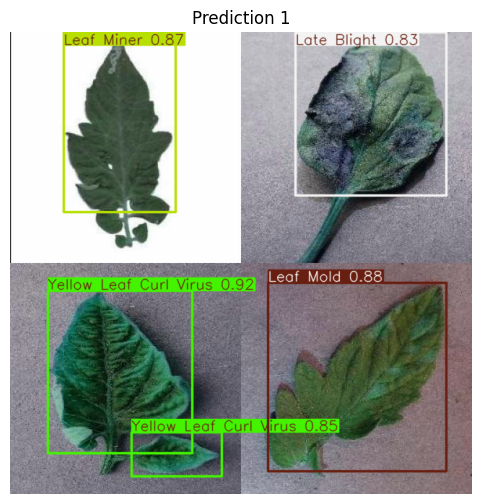

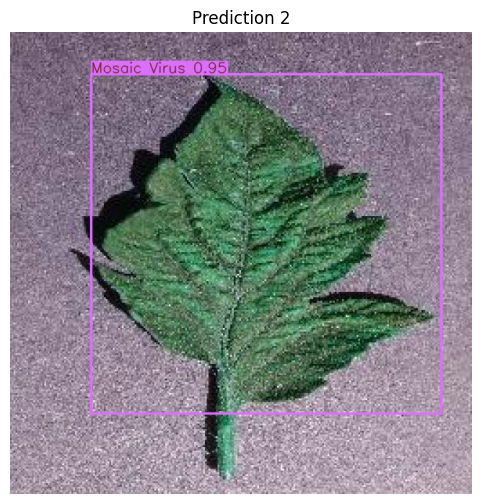

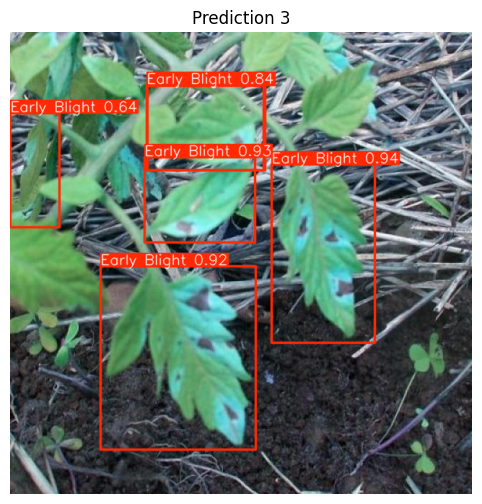

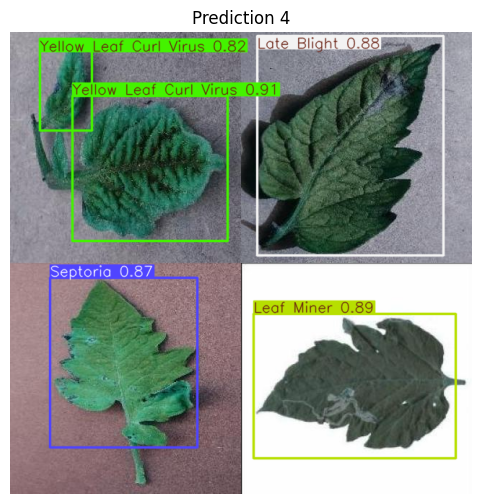

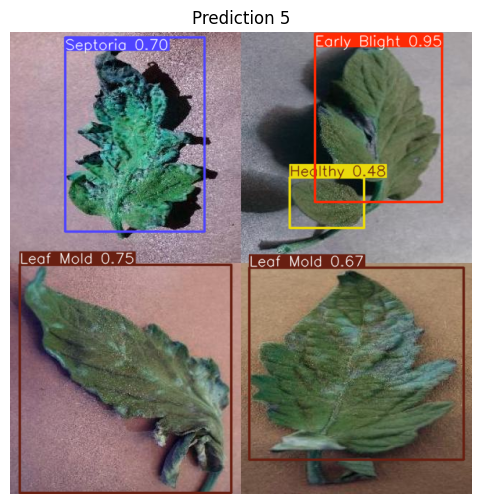

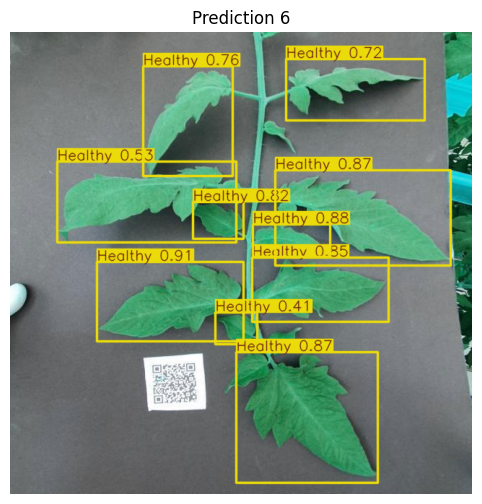

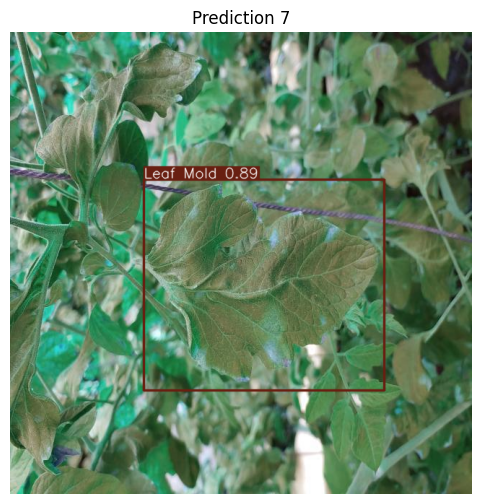

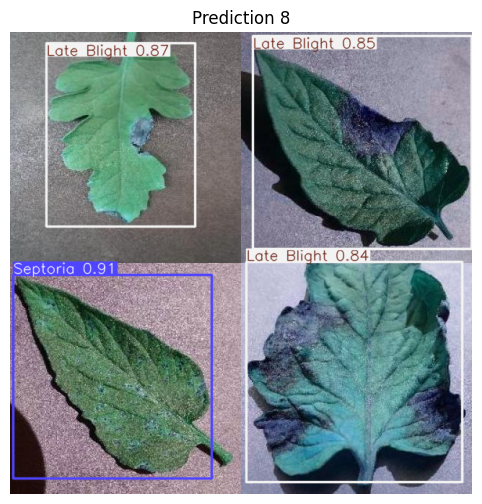

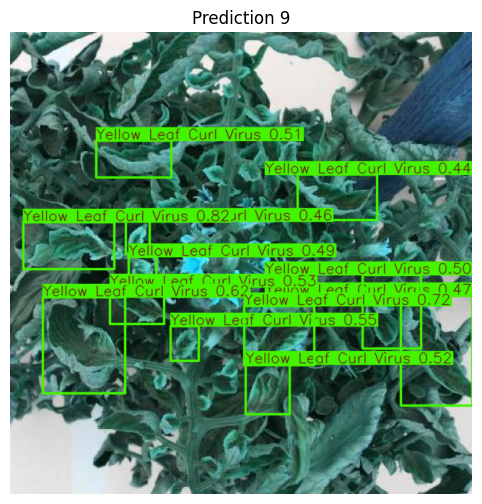

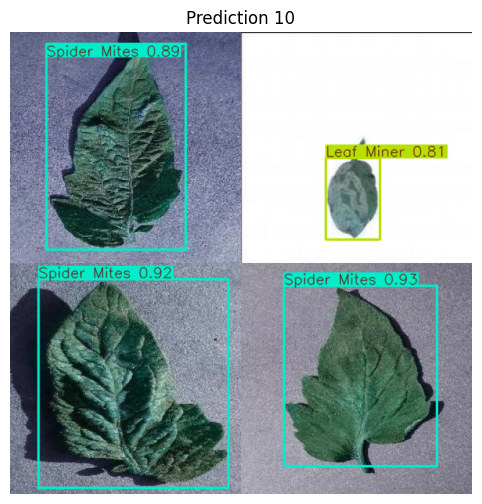

In [7]:
# Test nhận diện
model = YOLO("/kaggle/input/yolov10n-vt/pytorch/tomato/1/yolov10n-VT.pt")
model.to("cuda")

test_path_abs = '/kaggle/input/vietnameses-tomato-disease-dataset/YOLO/test/images'

image_paths = glob(os.path.join(test_path_abs, "*.jpg")) + glob(os.path.join(test_path_abs, "*.png"))

if len(image_paths) == 0:
    raise FileNotFoundError(f"Không tìm thấy ảnh nào trong thư mục test: {test_path_abs}")

sample_images = random.sample(image_paths, min(10, len(image_paths)))

results = model.predict(sample_images, save=False, conf=0.4)

for i, result in enumerate(results):
    im = result.plot()
    plt.figure(figsize=(8, 6))
    plt.imshow(im)
    plt.axis('off')
    plt.title(f"Prediction {i+1}")
    plt.show()